# Fake News Detection by Stance Prediction

The task is to detect fake news by **predicting the stance** associated to every new article using the __[FNC Dataset](https://github.com/FakeNewsChallenge/fnc-1)__.


#### Data Input & Preprocessing

In [1]:
import pandas as pd

merged = [None] * 2
for idx, prefix in enumerate(['train', 'test']):
    body_df = pd.read_csv(f'{prefix}_bodies.csv', index_col=0)
    stance_df = pd.read_csv(f'{prefix}_stances.csv')

    merged_df = pd.merge(stance_df, body_df, on='Body ID')
    merged_df = merged_df.rename(
        columns={'Headline': 'headline', 'Body ID': 'body_id',
                     'Stance': 'stance', 'articleBody': 'body'}
    )
    merged[idx] = merged_df

train_df, test_df = merged


#### Data Exploration

The training dataset consists of 49972 headline and article pairs.
The testing dataset consists of 25413 headline and article pairs.


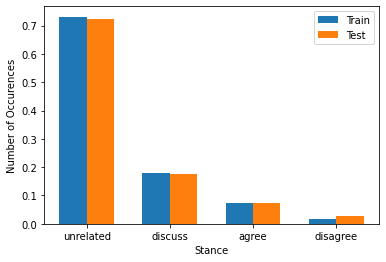

In [51]:
import matplotlib.pyplot as plt

print(f'The training dataset consists of {len(train_df)} headline and article pairs.')
print(f'The testing dataset consists of {len(test_df)} headline and article pairs.')

train_counts = train_df['stance'].value_counts(normalize=True)
test_counts = test_df['stance'].value_counts(normalize=True)

plt.figure()
plt.bar(train_counts.index,train_counts.values, width=-0.33, align='edge', label='Train')
plt.bar(test_counts.index,test_counts.values, width=0.33, align='edge', label='Test')
plt.legend()
plt.xlabel('Stance')
plt.ylabel('Number of Occurences')

plt.show()
